In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
#inspect table names in database
tables_in_database = inspect(engine)
tables_in_database.get_table_names()

['measurement', 'station']

In [8]:
#inspect columns for table "measurement" (names and data type)
columns_in_table_measurement = tables_in_database.get_columns('measurement')
for column in columns_in_table_measurement:
    print(column["name"], column["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
#inspect columns for table "station" (names and data type)
columns_in_table_station = tables_in_database.get_columns('station')
for column in columns_in_table_station:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

('2017-08-23',)
2016-08-23


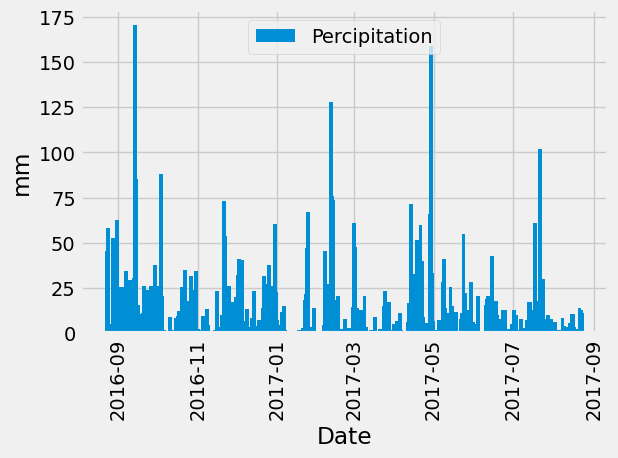

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

# Calculate the date one year from the last date in data set.
date_one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(date_one_year_ago)

# Perform a query to retrieve the date and precipitation scores
parameters_to_retrieve = [Measurement.date, Measurement.prcp]

data_for_one_year = session.query(*parameters_to_retrieve).\
        filter(func.strftime(Measurement.date) > "2016-08-22").\
        filter(func.strftime(Measurement.date) < "2017-08-24").all()

data_for_one_year

# Save the query results as a Pandas DataFrame. Explicitly set the column names
data_for_one_year_df = pd.DataFrame(data_for_one_year, columns=['date', 'prcp'])
data_for_one_year_df.dropna(inplace=True)
data_for_one_year_df.head()


# Sort the dataframe by date
data_for_one_year_df["date"] = pd.to_datetime(data_for_one_year_df["date"])
data_for_one_year_sorted_df = data_for_one_year_df.sort_values(by=['date'])
data_for_one_year_sorted_df.set_index('date', inplace=True)
plt.bar(data_for_one_year_sorted_df.index, data_for_one_year_sorted_df["prcp"], width=3)
plt.xlabel('Date')
plt.ylabel('mm')
plt.legend(['Percipitation'], loc='upper center')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
#define any empty list to append all calculated prameters
parameters_values_list = []

#calculate count
count = data_for_one_year_sorted_df["prcp"].count()
parameters_values_list.append(count)

#calculate mean
mean = data_for_one_year_sorted_df["prcp"].mean()
parameters_values_list.append(mean)

#calculate Std Dev
std_dev = data_for_one_year_sorted_df["prcp"].std()
parameters_values_list.append(std_dev)

#calculate minimum
minimum = data_for_one_year_sorted_df["prcp"].min()
parameters_values_list.append(minimum)

#calculate quartiles (25%, 50% and 75%)
quartiles = data_for_one_year_sorted_df["prcp"].quantile([0.25, 0.5, 0.75])
lowerq = quartiles[0.25]
parameters_values_list.append(lowerq)
midq = quartiles[0.5]
parameters_values_list.append(midq)
upperq = quartiles[0.75]
parameters_values_list.append(upperq)

#calculate maximum
maximum = data_for_one_year_sorted_df["prcp"].max()
parameters_values_list.append(maximum)

#DataFrame to hold all parameter
statistcs_df = pd.DataFrame(parameters_values_list, index=["count", "mean", "std", "min", "25%", "50%", "75%", "max"], columns=["Parameter"])
statistcs_df

,Parameter
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
number_of_stations = session.query(Measurement.station).group_by(Measurement.station).count()
number_of_stations

# Or, another way is as below
total_number_of_stations = session.query(func.count(Station.station)).all()
total_number_of_stations

[(9,)]

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
order_of_stations = [Measurement.station, func.count(Measurement.station)]

Order_of_stations = session.query(*order_of_stations).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
Order_of_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

Station USC00519281 has greatest number of observations.

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
for_most_active_station = [Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

Data_for_most_active_station = session.query(*for_most_active_station).filter(Measurement.station == 'USC00519281').all()
Data_for_most_active_station

[('USC00519281', 12.2, 29.4, 22.03582251082252)]

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_most_active_station_year = [Measurement.station, Measurement.date, Measurement.tobs]

temp_over_year_most_active_station = session.query(*temp_most_active_station_year).\
        filter(Measurement.station == 'USC00519281').\
        filter(func.strftime(Measurement.date) > "2016-08-22").\
        filter(func.strftime(Measurement.date) < "2017-08-24").all()
temp_over_year_most_active_station

[('USC00519281', '2016-08-23', 25.0),
 ('USC00519281', '2016-08-24', 25.0),
 ('USC00519281', '2016-08-25', 26.7),
 ('USC00519281', '2016-08-26', 26.7),
 ('USC00519281', '2016-08-27', 23.9),
 ('USC00519281', '2016-08-28', 22.8),
 ('USC00519281', '2016-08-29', 25.6),
 ('USC00519281', '2016-08-30', 25.0),
 ('USC00519281', '2016-08-31', 25.6),
 ('USC00519281', '2016-09-01', 26.7),
 ('USC00519281', '2016-09-02', 26.7),
 ('USC00519281', '2016-09-03', 25.6),
 ('USC00519281', '2016-09-04', 25.6),
 ('USC00519281', '2016-09-05', 25.6),
 ('USC00519281', '2016-09-06', 22.8),
 ('USC00519281', '2016-09-07', 23.3),
 ('USC00519281', '2016-09-08', 26.7),
 ('USC00519281', '2016-09-09', 26.1),
 ('USC00519281', '2016-09-10', 25.0),
 ('USC00519281', '2016-09-11', 26.7),
 ('USC00519281', '2016-09-12', 24.4),
 ('USC00519281', '2016-09-13', 26.1),
 ('USC00519281', '2016-09-14', 23.9),
 ('USC00519281', '2016-09-15', 26.1),
 ('USC00519281', '2016-09-16', 25.6),
 ('USC00519281', '2016-09-17', 26.1),
 ('USC005192

<function matplotlib.pyplot.show(close=None, block=None)>

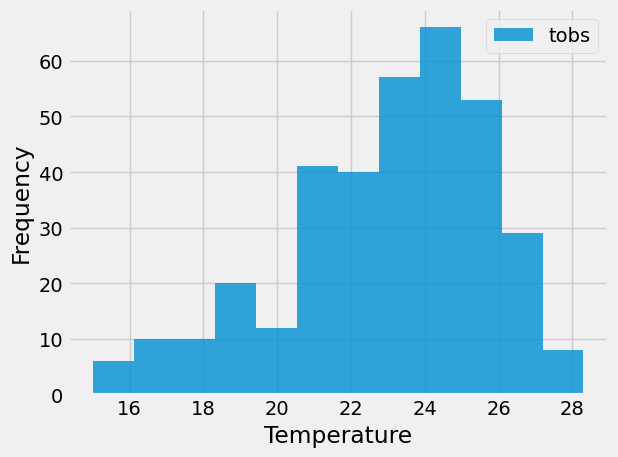

In [19]:
temp_over_year_most_active_station_df = pd.DataFrame(temp_over_year_most_active_station, columns=['station', 'date', 'tobs'])
temp_over_year_most_active_station_df.dropna(inplace=True)
temp_over_year_most_active_station_df.head()

plt.hist(temp_over_year_most_active_station_df["tobs"], bins=12, alpha=0.8)
plt.xlabel('Temperature')
plt.ylabel("Frequency")
plt.legend(['tobs'], loc='best')
plt.tight_layout()
plt.show

# Close Session

In [20]:
# Close Session
session.close()